In [32]:
import os
import cv2
import argparse
import librosa
import numpy as np

import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils import data
from torchvision import transforms
from torch.utils.data import Dataset

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import easydict
from sklearn.model_selection import train_test_split

In [33]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.amplitude_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_db_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [34]:
margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

# print(len(margs_trainvalid) + len(margs_test))
# print(len(nuss_trainvalid) + len(nuss_test))
# print(len(vocals_trainvalid) + len(vocals_test))

In [76]:
train_list = list(margs_train) + list(nuss_train) + list(vocals_train)
valid_list = list(margs_valid) + list(nuss_valid) + list(vocals_valid)
test_list = list(margs_test) + list(nuss_test) + list(vocals_test)
whole = train_list + valid_list + test_list
print('whole:', len(whole), 'train:', len(train_list), 'valid:', len(valid_list), 'test:', len(test_list))

whole: 9958 train: 7752 valid: 864 test: 1342


In [44]:
folder = '../dataset'
cnt, cnt2, cnt3 = 0, 0, 0
total_len = 0
train_len = 0
train_len_short = 0
valid_len = 0
test_len = 0
for ix, lis in enumerate(train_list):
    dat = torchaudio.info(os.path.join(folder, lis))
    train_len += dat.num_frames
    if dat.num_frames < 44100*2:
        cnt += 1
    if dat.num_frames < 44100*2.5:
        cnt2 += 1
        train_len_short += dat.num_frames
    if dat.num_frames > 44100*5:
        cnt3 += 1

for ix, lis in enumerate(valid_list):
    dat = torchaudio.info(os.path.join(folder, lis))
    valid_len += dat.num_frames

for ix, lis in enumerate(test_list):
    dat = torchaudio.info(os.path.join(folder, lis))
    test_len += dat.num_frames
    
total_len = train_len + valid_len + test_len
print('total:', np.round(total_len/44100.0/60,2), 'train:', np.round(train_len/44100.0/60,2), 'valid:', np.round(valid_len/44100.0/60,2), 'test:', np.round(test_len/44100.0/60,2))

total: 1231.11 train: 979.83 valid: 93.6 test: 157.68


In [53]:
a, sr = torchaudio.load(os.path.join(folder, lis))
a_pad = torch.nn.functional.pad(a[0], (0, int(44100*5)-a.shape[-1]), mode='constant', value=0)

torch.Size([513, 431, 2])


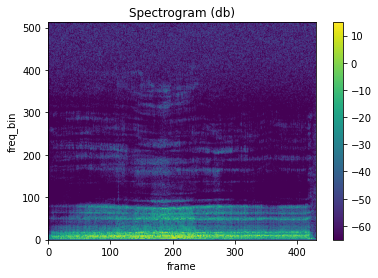

In [54]:
def get_comlex_spectrogram(waveform, n_fft = 1024, win_len = 1024, hop_len = 512, power=None):
    spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
    return_complex=0,
    )
    return spectrogram(waveform)

a.shape, a_pad.shape
a_spec = get_comlex_spectrogram(a_pad)

print(a_spec.shape)
plot_spectrogram(a_spec[:,:,1].pow(1))
play_audio(a_pad.unsqueeze(0), 44100)

In [55]:
a_spec.shape

torch.Size([513, 431, 2])

torch.Size([513, 431, 2])


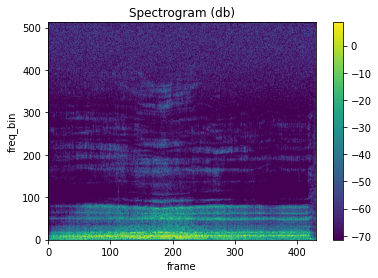

In [56]:
real = a_spec[:,:,0]
complx = a_spec[:,:,-1]
comb = torch.cat((real.unsqueeze(-1), complx.unsqueeze(-1)), -1)
a_istft = torch.istft(comb, n_fft=1024, win_length=1024, hop_length=512)
a_istft.shape

a_istft_spec = get_comlex_spectrogram(a_istft)

print(a_istft_spec.shape)
plot_spectrogram(a_istft_spec[:,:,0].pow(1))
play_audio(a_istft.unsqueeze(0), 44100)

NameError: name 'opt' is not defined

In [402]:
ALLMASKTYPES = ['time_masking', 'bbox', 'free_form']

class InpaintDataset(Dataset):
    def __init__(self, opt, split):
        self.opt = opt
        self.split = split
        
        self.get_list()
        
    def __getitem__(self, index):
        audio = self.get_audio(index)
        
        if self.split == 'TRAIN':
            if self.opt.mask_type == 'time_masking':
                mask = self.time_mask()
            if self.opt.mask_type == 'bbox':
                mask = self.bbox2mask()
            if self.opt.mask_type == 'free_form':
                mask = self.random_ff_mask()
        elif self.split in ['VALID', 'TEST']:
            if self.opt.mask_type == 'time_masking':
                masks_dir = '../split/fixedmask_time'
                mask = np.load(os.path.join(masks_dir, str(index)))
            if self.opt.mask_type == 'bbox':
                masks_dir = '../split/fixedmask_bbox'
                mask = np.load(os.path.join(masks_dir, str(index)))
            if self.opt.mask_type == 'free_form':
                masks_dir = '../split/fixedmask_freeform'
                mask = np.load(os.path.join(masks_dir, str(index)))

        audio = audio.permute(2, 0, 1).contiguous()
        mask = torch.from_numpy(mask.astype(np.float32)).contiguous()
        
        return audio, mask
    
    def get_list(self):
        margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
        margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
        nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
        nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
        vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
        vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

        margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

        if self.split == 'TRAIN':
            train_list = list(margs_train) + list(nuss_train) + list(vocals_train)
            self.fl = train_list
        elif self.split == 'VALID':
            valid_list = list(margs_valid) + list(nuss_valid) + list(vocals_valid)
            self.fl = valid_list
        elif self.split == 'TEST':
            test_list = list(margs_test) + list(nuss_valid) + list(vocals_test)
            self.fl = test_list
    
    def get_audio(self, index):
        fn = self.fl[index]
        audio_path = os.path.join(self.opt.data_dir, fn)
        audio, sr = torchaudio.load(audio_path)
        random_idx = int(np.floor(np.random.random(1) * (audio.shape[-1]-self.opt.input_length)))
        audio = audio[:,random_idx:random_idx+self.opt.input_length]
        audio_pad = torch.nn.functional.pad(audio, (0, 44100*5-audio.shape[-1]), mode='constant', value=0)
        return audio_pad

    def random_bbox(self):
        max_freq_ix = self.opt.image_height - self.opt.bbox_shape
        max_frame_ix = self.opt.image_width - opt.bbox_shape

        box_freq_ix = np.random.randint(max_freq_ix)
        box_frame_ix = np.random.randint(max_frame_ix)

        return (box_freq_ix, box_frame_ix, self.opt.bbox_shape, self.opt.bbox_shape)

    def time_mask(self):
        mask_width = np.random.randint(low=8, high=87)
        max_frame_ix = self.opt.image_width - mask_width
        t = np.random.randint(max_frame_ix)
        mask = np.zeros((self.opt.image_height, self.opt.image_width))
        mask[:,t:t+mask_width] = 1
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def bbox2mask(self):
        bboxs = []
        times = np.random.randint(8)
        for i in range(times):
            bbox = random_bbox(self.opt)
            bboxs.append(bbox)
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        for bbox in bboxs:
            h = int(bbox[2] * 0.1) + np.random.randint(int(bbox[2] * 0.2 + 1))
            w = int(bbox[3] * 0.1) + np.random.randint(int(bbox[3] * 0.2) + 1)
            mask[(bbox[0] + h) : (bbox[0] + bbox[2] - h), (bbox[1] + w) : (bbox[1] + bbox[3] - w)] = 1.
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def random_ff_mask(self):
        """Generate a random free form mask with configuration.
        Args:
            config: Config should have configuration including IMG_SHAPES,
                VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
        Returns:
            tuple: (top, left, height, width)
        """
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        max_angle = 4
        max_len = 200
        max_width = 20
        times = np.random.randint(7)
        for i in range(times):
            start_x = np.random.randint(self.opt.image_width)
            start_y = np.random.randint(self.opt.image_height)
            for j in range(1 + np.random.randint(5)):
                angle = 0.01 + np.random.randint(max_angle)
                if i % 2 == 0:
                    angle = 2 * 3.1415926 - angle
                length = 10 + np.random.randint(max_len)
                brush_w = 5 + np.random.randint(max_width)
                end_x = (start_x + length * np.sin(angle)).astype(np.int32)
                end_y = (start_y + length * np.cos(angle)).astype(np.int32)
                cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
                start_x, start_y = end_x, end_y
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def __len__(self):
        return len(self.fl)

In [62]:
5/431*8

0.09280742459396751

In [279]:
opt = easydict.EasyDict({
    "data_dir": '../dataset',
    "input_length": 220500,
    "image_height": 513,
    "image_width": 431,
    "bbox_shape": 120,
    "mask_type": 'free_form'
    })

In [280]:
train_dataset = InpaintDataset(opt, split='TRAIN')
valid_dataset = InpaintDataset(opt, split='VALID')
test_dataset = InpaintDataset(opt, split='TEST')

audio, mask = train_dataset[1]
audio.shape, mask.shape

(torch.Size([1, 220500]), torch.Size([1, 513, 431]))

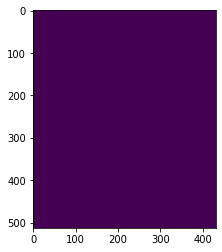

In [281]:
plt.imshow(mask[0])

In [282]:
len(valid_dataset), len(test_dataset)

(864, 1250)

In [276]:
def time_mask_fixed():
    mask_width = np.random.randint(low=8, high=87)
    max_frame_ix = opt.image_width - mask_width
    t = np.random.randint(max_frame_ix)
    mask = np.zeros((opt.image_height, opt.image_width))
    mask[:,t:t+mask_width] = 1
    return mask.reshape((1, ) + mask.shape).astype(np.float32)


def random_bbox_fixed(opt):
    max_freq_ix = opt.image_height - opt.bbox_shape
    max_frame_ix = opt.image_width - opt.bbox_shape

    box_freq_ix = np.random.randint(max_freq_ix)
    box_frame_ix = np.random.randint(max_frame_ix)

    return (box_freq_ix, box_frame_ix, opt.bbox_shape, opt.bbox_shape)

def bbox2mask_fixed():
    bboxs = []
    times = np.random.randint(8)
    for i in range(times):
        bbox = random_bbox_fixed(opt)
        bboxs.append(bbox)
    mask = np.zeros((opt.image_height, opt.image_width), np.float32)
    for bbox in bboxs:
        h = int(bbox[2] * 0.1) + np.random.randint(int(bbox[2] * 0.2 + 1))
        w = int(bbox[3] * 0.1) + np.random.randint(int(bbox[3] * 0.2) + 1)
        mask[(bbox[0] + h) : (bbox[0] + bbox[2] - h), (bbox[1] + w) : (bbox[1] + bbox[3] - w)] = 1.
    return mask.reshape((1, ) + mask.shape).astype(np.float32)

def random_ff_mask_fixed():
    """Generate a random free form mask with configuration.
    Args:
        config: Config should have configuration including IMG_SHAPES,
            VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
    Returns:
        tuple: (top, left, height, width)
    """
    mask = np.zeros((opt.image_height, opt.image_width), np.float32)
    max_angle = 4
    max_len = 200
    max_width = 20
    times = np.random.randint(7)
    for i in range(times):
        start_x = np.random.randint(opt.image_width)
        start_y = np.random.randint(opt.image_height)
        for j in range(1 + np.random.randint(5)):
            angle = 0.01 + np.random.randint(max_angle)
            if i % 2 == 0:
                angle = 2 * 3.1415926 - angle
            length = 10 + np.random.randint(max_len)
            brush_w = 5 + np.random.randint(max_width)
            end_x = (start_x + length * np.sin(angle)).astype(np.int32)
            end_y = (start_y + length * np.cos(angle)).astype(np.int32)
            cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
            start_x, start_y = end_x, end_y
    return mask.reshape((1, ) + mask.shape).astype(np.float32)

In [277]:
for i in range(1500):
    time_mask = time_mask_fixed()
    bbox_mask = bbox2mask_fixed()
    ff_mask = random_ff_mask_fixed()
#     np.save('../split/fixedmask_time/' + str(i) + '.npy', time_mask)
#     np.save('../split/fixedmask_bbox/' + str(i) + '.npy', bbox_mask)
#     np.save('../split/fixedmask_freeform/' + str(i) + '.npy', ff_mask)
    

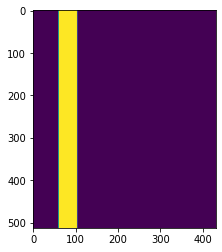

In [268]:
plt.imshow(mask[0])

In [284]:
audio.max()

tensor(0.2205)

In [290]:
def get_comlex_spectrogram(waveform, n_fft = 1024, win_len = 1024, hop_len = 512, power=None):
    spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
    )
    return spectrogram(waveform)

In [381]:
mmax_value = 0
mmin_value = 0
for i, wh in enumerate(whole):
    y, sr = torchaudio.load(os.path.join(folder, wh))
    spec = get_comlex_spectrogram(y)
    max_value = spec.max()
    min_value = spec.min()
    if max_value > mmax_value:
        print('max update:', max_value)
        mmax_value = max_value
    if min_value < mmin_value:
        print('min update:', min_value)
        mmin_value = min_value
    

max update: tensor(64.0161)
min update: tensor(-57.6523)
min update: tensor(-59.0165)
min update: tensor(-59.6628)
max update: tensor(105.4215)
min update: tensor(-86.4876)
min update: tensor(-113.1130)
max update: tensor(105.5283)
max update: tensor(108.2646)
min update: tensor(-184.8884)
max update: tensor(123.6034)
max update: tensor(125.6498)
max update: tensor(147.9716)
max update: tensor(180.1203)
min update: tensor(-200.2883)
max update: tensor(185.2882)
min update: tensor(-208.8629)
max update: tensor(189.0886)
max update: tensor(220.6312)
min update: tensor(-209.2620)
min update: tensor(-212.7511)
min update: tensor(-217.5806)
max update: tensor(286.1467)
min update: tensor(-278.4837)
min update: tensor(-281.4670)
max update: tensor(297.9837)
min update: tensor(-282.2278)
min update: tensor(-295.8867)


In [ ]:
import os
import cv2
import argparse
import librosa
import numpy as np

import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils import data
from torchvision import transforms
from torch.utils.data import Dataset

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import easydict
from sklearn.model_selection import train_test_split
ALLMASKTYPES = ['time_masking', 'bbox', 'free_form']


class InpaintDataset(Dataset):
    def __init__(self, opt, split):
        self.opt = opt
        self.split = split
        
        self.get_list()
        
    def __getitem__(self, index):
        audio = self.get_audio(index)
        complex_spec = self.get_comlex_spectrogram(audio)

        if self.split == 'TRAIN':
            if self.opt.mask_type == 'time_masking':
                mask = self.time_mask()
            if self.opt.mask_type == 'bbox':
                mask = self.bbox2mask()
            if self.opt.mask_type == 'free_form':
                mask = self.random_ff_mask()
        elif self.split in ['VALID', 'TEST']:
            if self.opt.mask_type == 'time_masking':
                masks_dir = '../split/fixedmask_time'
                mask = np.load(os.path.join(masks_dir, str(index)))
            if self.opt.mask_type == 'bbox':
                masks_dir = '../split/fixedmask_bbox'
                mask = np.load(os.path.join(masks_dir, str(index)))
            if self.opt.mask_type == 'free_form':
                masks_dir = '../split/fixedmask_freeform'
                mask = np.load(os.path.join(masks_dir, str(index)))

        complex_spec = complex_spec.permute(2, 0, 1).contiguous()
        mask = torch.from_numpy(mask.astype(np.float32)).contiguous()
        
        return complex_spec, mask
    
    def get_list(self):
        margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
        margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
        nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
        nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
        vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
        vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

        margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

        if self.split == 'TRAIN':
            train_list = list(margs_train) + list(nuss_train) + list(vocals_train)
            self.fl = train_list
        elif self.split == 'VALID':
            valid_list = list(margs_valid) + list(nuss_valid) + list(vocals_valid)
            self.fl = valid_list
        elif self.split == 'TEST':
            test_list = list(margs_test) + list(nuss_valid) + list(vocals_test)
            self.fl = test_list
    
    def get_audio(self, index):
        fn = self.fl[index]
        audio_path = os.path.join(self.opt.data_dir, fn)
        audio, sr = torchaudio.load(audio_path)
        random_idx = int(np.floor(np.random.random(1) * (audio.shape[-1]-self.opt.input_length)))
        audio = audio[:,random_idx:random_idx+self.opt.input_length]
        audio_pad = torch.nn.functional.pad(audio, (0, 44100*5-audio.shape[-1]), mode='constant', value=0)
        return audio_pad

    def get_comlex_spectrogram(self,waveform, n_fft = 1024, win_len = 1024, hop_len = 512, power=None):
        spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
        )
        return spectrogram(waveform)

    def random_bbox(self):
        max_freq_ix = self.opt.image_height - self.opt.bbox_shape
        max_frame_ix = self.opt.image_width - opt.bbox_shape

        box_freq_ix = np.random.randint(max_freq_ix)
        box_frame_ix = np.random.randint(max_frame_ix)

        return (box_freq_ix, box_frame_ix, self.opt.bbox_shape, self.opt.bbox_shape)

    def time_mask(self):
        mask_width = np.random.randint(low=8, high=87)
        max_frame_ix = self.opt.image_width - mask_width
        t = np.random.randint(max_frame_ix)
        mask = np.zeros((self.opt.image_height, self.opt.image_width))
        mask[:,t:t+mask_width] = 1
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def bbox2mask(self):
        bboxs = []
        times = np.random.randint(8)
        for i in range(times):
            bbox = random_bbox(self.opt)
            bboxs.append(bbox)
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        for bbox in bboxs:
            h = int(bbox[2] * 0.1) + np.random.randint(int(bbox[2] * 0.2 + 1))
            w = int(bbox[3] * 0.1) + np.random.randint(int(bbox[3] * 0.2) + 1)
            mask[(bbox[0] + h) : (bbox[0] + bbox[2] - h), (bbox[1] + w) : (bbox[1] + bbox[3] - w)] = 1.
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def random_ff_mask(self):
        """Generate a random free form mask with configuration.
        Args:
            config: Config should have configuration including IMG_SHAPES,
                VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
        Returns:
            tuple: (top, left, height, width)
        """
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        max_angle = 4
        max_len = 200
        max_width = 20
        times = np.random.randint(7)
        for i in range(times):
            start_x = np.random.randint(self.opt.image_width)
            start_y = np.random.randint(self.opt.image_height)
            for j in range(1 + np.random.randint(5)):
                angle = 0.01 + np.random.randint(max_angle)
                if i % 2 == 0:
                    angle = 2 * 3.1415926 - angle
                length = 10 + np.random.randint(max_len)
                brush_w = 5 + np.random.randint(max_width)
                end_x = (start_x + length * np.sin(angle)).astype(np.int32)
                end_y = (start_y + length * np.cos(angle)).astype(np.int32)
                cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
                start_x, start_y = end_x, end_y
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def __len__(self):
        return len(self.fl)

In [ ]:
 = dataset.InpaintDataset(opt, split='VALID')

In [10]:
bbox_dir = '../split/fixedmask_bbox'
time_dir = '../split/fixedmask_time'
freeform_dir = '../split/fixedmask_freeform'


In [23]:
bbox_list = glob.glob(os.path.join(bbox_dir, '*'))
time_list = glob.glob(os.path.join(time_dir, '*'))
freeform_list = glob.glob(os.path.join(freeform_dir, '*'))


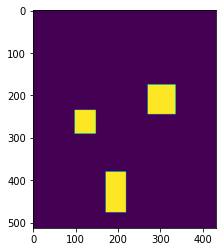

In [63]:
bbox_data = np.load(bbox_list[2])
plt.imshow(bbox_data[0])

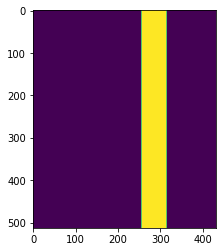

In [30]:
time_data = np.load(time_list[4])
plt.imshow(time_data[0])

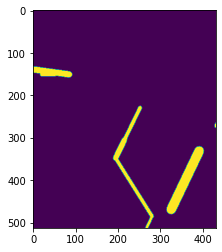

In [73]:
freeform_data = np.load(freeform_list[11])
plt.imshow(freeform_data[0])

In [74]:
freeform_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [75]:
1-freeform_data

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)